In [ ]:
import os
import math
import io
import time
import numpy as np
import tensorflow as tf
import tiktoken
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.utils import Progbar

# -----------------------
# Utility: Download TFRecord Files from URLs
# -----------------------
def download_tfrecord_files(url_dict):
    local_paths = {}
    for fname, url in url_dict.items():
        try:
            path = tf.keras.utils.get_file(fname, url)
            local_paths[fname] = path
            tf.get_logger().info(f"Downloaded {fname} to {path}")
        except Exception as e:
            tf.get_logger().error(f"Error downloading {fname} from {url}: {e}")
            raise e
    return local_paths

# -----------------------
# TFRecord Parsing Function
# -----------------------
def parse_tfrecord(example_proto):
    feature_description = {'tokens': tf.io.FixedLenFeature([512], tf.int64)}
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    tokens = parsed_example['tokens']
    return tokens[:-1], tokens[1:]

# -----------------------
# Transformer Model Components & Helper Functions
# -----------------------
class RMSNorm(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):  # Updated epsilon to 1e-5
        super(RMSNorm, self).__init__(**kwargs)
        self.epsilon = epsilon
    def build(self, input_shape):
        self.gamma = self.add_weight(name="gamma",
                                     shape=input_shape[-1:],
                                     initializer="ones",
                                     trainable=True)
        super(RMSNorm, self).build(input_shape)
    def call(self, inputs):
        gamma = tf.cast(self.gamma, inputs.dtype)
        rms = tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
        return inputs * gamma / rms

def apply_rope(x, sin, cos):
    sin = tf.cast(sin, x.dtype)
    cos = tf.cast(cos, x.dtype)
    head_dim = tf.shape(x)[-1]
    x = tf.reshape(x, tf.concat([tf.shape(x)[:-1], [head_dim // 2, 2]], axis=0))
    x1, x2 = x[..., 0], x[..., 1]
    sin_tensor = tf.expand_dims(tf.expand_dims(sin, axis=0), axis=2)
    cos_tensor = tf.expand_dims(tf.expand_dims(cos, axis=0), axis=2)
    x_rotated_first = x1 * cos_tensor - x2 * sin_tensor
    x_rotated_second = x1 * sin_tensor + x2 * cos_tensor
    x = tf.stack([x_rotated_first, x_rotated_second], axis=-1)
    return tf.reshape(x, tf.concat([tf.shape(x)[:-2], [head_dim]], axis=0))

class TiedDense(layers.Layer):
    def __init__(self, tied_to, **kwargs):
        super(TiedDense, self).__init__(**kwargs)
        self.tied_to = tied_to
    def call(self, inputs):
        tied_embeddings = tf.cast(self.tied_to.embeddings, inputs.dtype)
        return tf.matmul(inputs, tied_embeddings, transpose_b=True)
    def get_config(self):
        config = super().get_config()
        config.update({"tied_to": self.tied_to.name})
        return config

class RotarySelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1, **kwargs):
        super(RotarySelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != embed_dim:
            raise ValueError("embed_dim must be divisible by num_heads")
        self.dropout_rate = dropout_rate
    def build(self, input_shape):
        robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.query_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.key_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.value_dense = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.out_dense   = layers.Dense(self.embed_dim, kernel_initializer=robust_init)
        self.dropout     = layers.Dropout(self.dropout_rate)
        super(RotarySelfAttention, self).build(input_shape)
    def call(self, inputs, training=False, use_causal_mask=True):
        batch_size = tf.shape(inputs)[0]
        seq_len    = tf.shape(inputs)[1]
        query = self.query_dense(inputs)
        key   = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = tf.reshape(query, (batch_size, seq_len, self.num_heads, self.head_dim))
        key   = tf.reshape(key, (batch_size, seq_len, self.num_heads, self.head_dim))
        value = tf.reshape(value, (batch_size, seq_len, self.num_heads, self.head_dim))
        position = tf.cast(tf.range(seq_len), tf.float32)
        head_dim_int = self.head_dim
        inv_freq = 1.0 / (10000 ** (tf.cast(tf.range(0, head_dim_int, 2), tf.float32) / tf.cast(head_dim_int, tf.float32)))
        sinusoid_inp = tf.tensordot(position, inv_freq, axes=0)
        sin = tf.sin(sinusoid_inp)
        cos = tf.cos(sinusoid_inp)
        query = apply_rope(query, sin, cos)
        key   = apply_rope(key, sin, cos)
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key   = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.transpose(value, perm=[0, 2, 1, 3])
        scaling = tf.cast(self.head_dim, query.dtype) ** -0.5
        query = query * scaling
        attn_logits = tf.matmul(query, key, transpose_b=True)
        if use_causal_mask:
            mask = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=query.dtype), -1, 0)
            mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
            attn_logits = attn_logits * mask + tf.cast(-1e4, attn_logits.dtype) * (1 - mask)
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)
        attn_weights = self.dropout(attn_weights, training=training)
        attn_output = tf.matmul(attn_weights, value)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        attn_output = tf.reshape(attn_output, (batch_size, seq_len, self.embed_dim))
        output = self.out_dense(attn_output)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = RotarySelfAttention(embed_dim, num_heads, dropout_rate)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.norm1 = RMSNorm(epsilon=1e-5)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation=tf.nn.gelu,
                         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
            layers.Dense(embed_dim, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))
        ])
        self.dropout2 = layers.Dropout(dropout_rate)
        self.norm2 = RMSNorm(epsilon=1e-5)
    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, training=training, use_causal_mask=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

def create_transformer_model(vocab_size, sequence_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate=0.1):
    inputs = layers.Input(shape=(sequence_length,), dtype=tf.int32)
    robust_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    token_embedding = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       embeddings_initializer=robust_init,
                                       name="token_embedding")
    x = token_embedding(inputs)
    for i in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate, name=f"transformer_block_{i}")(x)
    x = RMSNorm(epsilon=1e-5, name="final_rmsnorm")(x)
    logits = TiedDense(token_embedding, name="output_projection")(x)
    # Since we are using full precision, this cast is optional.
    logits = layers.Lambda(lambda x: tf.cast(x, tf.float32))(logits)
    return models.Model(inputs=inputs, outputs=logits)

# -----------------------
# Custom Perplexity Metric
# -----------------------
class Perplexity(tf.keras.metrics.Metric):
    def __init__(self, name='perplexity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.ce_tracker = tf.keras.metrics.Mean(name="crossentropy_mean", dtype=tf.float32)
    def update_state(self, y_true, y_pred, sample_weight=None):
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        self.ce_tracker.update_state(ce, sample_weight=sample_weight)
    def result(self):
        avg_ce = self.ce_tracker.result()
        return tf.exp(avg_ce)
    def reset_state(self):
        self.ce_tracker.reset_state()

# -----------------------
# Helper Function to Exclude Certain Parameters from Weight Decay
# -----------------------
def should_apply_weight_decay(var):
    var_name = var.name.lower()
    if "bias" in var_name:
        return False
    if "norm" in var_name or "rmsnorm" in var_name:
        return False
    if "token_embedding/embeddings" in var_name:
        return False
    return True

# New learning rate schedule with warmup and cosine annealing decay.
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, total_steps, warmup_steps, alpha=0.0):
        """
        Args:
          initial_lr: The peak learning rate.
          total_steps: Total number of training steps.
          warmup_steps: Number of steps for the warmup phase.
          alpha: Final learning rate value as a fraction of initial_lr (default 0.0 means decay to 0).
        """
        super(WarmUpCosineDecay, self).__init__()
        self.initial_lr = initial_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warmup: linearly increase the learning rate
        warmup_lr = self.initial_lr * (step / tf.cast(self.warmup_steps, tf.float32))

        # Cosine annealing: decay from initial_lr to initial_lr * alpha
        progress = (step - self.warmup_steps) / tf.cast(self.total_steps - self.warmup_steps, tf.float32)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cosine_decay = 0.5 * (1 + tf.cos(math.pi * progress))
        decayed_lr = self.initial_lr * ((1 - self.alpha) * cosine_decay + self.alpha)

        # Use warmup_lr for steps within warmup_steps, otherwise decayed_lr.
        lr = tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: decayed_lr)
        return lr

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
            "alpha": self.alpha,
        }

def full_precision_training_main():
    """
    Full precision training script with weight decay and a cosine annealing learning rate schedule.
    This version restores from the last weights file if available.
    """

    # ------------------------------------------------
    # 1. Create a dict of TFRecord file names -> remote URLs for pre-shuffled training files
    # ------------------------------------------------
    tfrecord_url_dict = {
        "round1.tfrecord":
            "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/concatenated_shuffled.tfrecord?download=true",
        "round2.tfrecord":
            "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/reshuffled_round2.tfrecord?download=true",
        "round3.tfrecord":
            "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/reshuffled_round3.tfrecord?download=true",
        "round4.tfrecord":
            "https://huggingface.co/datasets/tonadeleon/books_and_conversations/resolve/main/reshuffled_round4.tfrecord?download=true",
    }

    # Download TFRecord files.
    local_paths_dict = download_tfrecord_files(tfrecord_url_dict)
    # For validation, we use all files combined.
    combined_tfrecord_paths = list(local_paths_dict.values())

    # Total sequences and validation split size.
    total_sequences = 1090386 + 1276920 + 1139206 + 616193
    val_size = int(0.002 * total_sequences)

    # ------------------------------------------------
    # 2. Create Full Dataset (Parsed & Cached) for Validation
    # ------------------------------------------------
    full_dataset = tf.data.TFRecordDataset(
        combined_tfrecord_paths,
        num_parallel_reads=tf.data.AUTOTUNE
    )
    full_dataset = full_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    full_dataset = full_dataset.cache()

    # ------------------------------------------------
    # 3. Split into Validation (unchanged)
    # ------------------------------------------------
    val_dataset = full_dataset.take(val_size)
    val_dataset = val_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    # -----------------------
    # 4. Hyperparameters
    # -----------------------
    BATCH_SIZE = 32
    steps_per_epoch = 3000
    num_rounds = 4  # Four rounds (one per pre-shuffled file)
    epochs_per_round = 39  # 39 epochs per round (~98% of the training set per file)
    total_scheduled_epochs = num_rounds * epochs_per_round
    early_stopping_patience = 25

    initial_lr = 2.5e-4
    total_steps = total_scheduled_epochs * steps_per_epoch
    warmup_steps = int(12000)

    SEQUENCE_LENGTH = 512  # Note: parse_tfrecord returns 511 tokens for x and y.
    embed_dim = 768
    num_heads = 12
    ff_dim = 3072
    num_layers = 12
    dropout_rate = 0.1

    # -----------------------
    # 5. GPU Setup / Mirrored Strategy
    # -----------------------
    # No mixed precision is set for full precision training.
    tf.config.optimizer.set_jit(True)
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices (full precision training): {strategy.num_replicas_in_sync}", flush=True)

    gpt2_encoding = tiktoken.get_encoding("gpt2")
    vocab_size = gpt2_encoding.n_vocab

    with strategy.scope():
        model = create_transformer_model(
            vocab_size=vocab_size,
            sequence_length=SEQUENCE_LENGTH - 1,
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            dropout_rate=dropout_rate
        )
        lr_schedule = WarmUpCosineDecay(initial_lr, total_steps, warmup_steps, alpha=0.0)
        base_optimizer = optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=0.01,
            beta_1=0.9,
            beta_2=0.995,
            clipnorm=.6
        )
        # Use the base optimizer directly for full precision.
        optimizer = base_optimizer
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    stream = io.StringIO()
    model.summary(print_fn=lambda x: stream.write(x + "\n"))
    print(stream.getvalue(), flush=True)

    # -----------------------
    # 6. Checkpoint Setup and Restoration
    # -----------------------
    if os.path.exists("last_model.h5"):
        model.load_weights("last_model.h5")
        print("Restored from last weights file: last_model.h5", flush=True)
        initial_global_epoch = 0  # Adjust if necessary
    else:
        initial_global_epoch = 0

    # Create a global epoch counter.
    global_epoch = tf.Variable(initial_global_epoch, trainable=False, dtype=tf.int64)
    global_step = tf.Variable(0, trainable=False, dtype=tf.int64)

    # -----------------------
    # 7. Prepare Datasets for Repeated Rounds (Training set: load one pre-shuffled file per round)
    # -----------------------
    # Note: Since the training files are already pre-shuffled, no additional shuffling is performed.
    def build_train_dataset(train_ds):
        return train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    # -----------------------
    # 8. Metrics and Global Step
    # -----------------------
    train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
    train_perplexity_metric = Perplexity(name='train_perplexity')
    val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
    val_perplexity_metric = Perplexity(name='val_perplexity')

    @tf.function
    def train_step(x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        global_step.assign_add(1)
        return loss_value, logits

    # -----------------------
    # 9. Main Training Loop: Multiple Rounds (Using Progbar)
    # -----------------------
    train_losses = []
    val_losses = []
    train_perplexities = []
    val_perplexities = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    round_count = 0
    training_file_list = list(local_paths_dict.values())  # List of individual pre-shuffled training files
    for r in range(num_rounds):
        round_count += 1
        print(f"\n=== Full Precision Training: Round {round_count}/{num_rounds} ===", flush=True)
        # Load the training dataset for the current round from the corresponding file
        current_train_file = training_file_list[r]
        train_dataset_current = tf.data.TFRecordDataset(
            current_train_file,
            num_parallel_reads=tf.data.AUTOTUNE
        )
        train_dataset_current = train_dataset_current.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
        train_dataset_current = train_dataset_current.cache()
        train_dataset = build_train_dataset(train_dataset_current)

        # Create a continuous iterator for the entire round to ensure unique batches
        round_iterator = iter(train_dataset)

        for e in range(epochs_per_round):
            current_epoch = initial_global_epoch + e + 1 + (r * epochs_per_round)
            print(f"\n[Cosine] Starting epoch {current_epoch}/{total_scheduled_epochs} (round {r+1} epoch {e+1})", flush=True)
            train_loss_metric.reset_state()
            train_perplexity_metric.reset_state()
            progbar = Progbar(steps_per_epoch)
            for step in range(steps_per_epoch):
                x_batch_train, y_batch_train = next(round_iterator)
                loss_value, logits = train_step(x_batch_train, y_batch_train)
                train_loss_metric.update_state(loss_value)
                train_perplexity_metric.update_state(y_batch_train, logits)
                progbar.update(step + 1, values=[
                    ("loss", train_loss_metric.result().numpy()),
                    ("ppl", train_perplexity_metric.result().numpy())
                ])
            val_loss_metric.reset_state()
            val_perplexity_metric.reset_state()
            for x_batch_val, y_batch_val in val_dataset:
                val_logits = model(x_batch_val, training=False)
                val_loss = loss_fn(y_batch_val, val_logits)
                val_loss_metric.update_state(val_loss)
                val_perplexity_metric.update_state(y_batch_val, val_logits)
            current_train_loss = train_loss_metric.result().numpy()
            current_val_loss = val_loss_metric.result().numpy()
            current_train_perplexity = train_perplexity_metric.result().numpy()
            current_val_perplexity = val_perplexity_metric.result().numpy()
            train_losses.append(current_train_loss)
            val_losses.append(current_val_loss)
            train_perplexities.append(current_train_perplexity)
            val_perplexities.append(current_val_perplexity)
            print(f"[Cosine] Epoch {current_epoch}/{total_scheduled_epochs} completed:", flush=True)
            print(f"         Train Loss = {current_train_loss:.4f}, Train Perplexity = {current_train_perplexity:.4f}", flush=True)
            print(f"         Val   Loss = {current_val_loss:.4f}, Val   Perplexity = {current_val_perplexity:.4f}", flush=True)
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                epochs_without_improvement = 0
                model.save_weights("best_model.h5", save_format="h5")
                print("  --> New best model saved to best_model.h5", flush=True)
            else:
                epochs_without_improvement += 1
                print(f"  --> No improvement for {epochs_without_improvement} epoch(s).", flush=True)
            model.save_weights("last_model.h5", save_format="h5")
            print("  --> Last model saved to last_model.h5", flush=True)
            if epochs_without_improvement >= early_stopping_patience:
                print(f"\n[Cosine] Early stopping triggered after {early_stopping_patience} epochs with no improvement.", flush=True)
                global_epoch.assign_add(1)
                break
            global_epoch.assign_add(1)
        if epochs_without_improvement >= early_stopping_patience:
            break

    # -----------------------
    # 10. Plotting Results
    # -----------------------
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
    plt.title('Cosine Training: Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_perplexities, marker='o', label='Training Perplexity')
    plt.plot(epochs_range, val_perplexities, marker='o', label='Validation Perplexity')
    plt.title('Cosine Training: Perplexity over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Full precision training complete.", flush=True)

if __name__ == '__main__':
    full_precision_training_main()


# Model Architecture

| Layer (type)                            | Output Shape       | Param #     |
|-----------------------------------------|--------------------|-------------|
| input_1 (InputLayer)                    | [(None, 511)]      | 0           |
| token_embedding (Embedding)             | (None, 511, 768)   | 38,597,376  |
| transformer_block_0 (TransformerBlock)  | (None, 511, 768)   | 7,086,336   |
| transformer_block_1 (TransformerBlock)  | (None, 511, 768)   | 7,086,336   |
| transformer_block_2 (TransformerBlock)  | (None, 511, 768)   | 7,086,336   |
| ... (9 more transformer blocks)     | ...                | ...         |
| final_rmsnorm (RMSNorm)                   | (None, 511, 768)   | 768         |
| output_projection (TiedDense)           | (None, 511, 50257) | 38,597,376  |
| lambda (Lambda)                         | (None, 511, 50257) | 0           |

**Total params:** 123,634,176  
**Trainable params:** 123,634,176  
**Non-trainable params:** 0  

---


# Training Logs (All 156 Epochs)

Below is the complete table with the metrics from each epoch as extracted manually from the logs:

| Epoch | Train Loss | Train Perplexity | Val Loss | Val Perplexity |
|:-----:|:----------:|:----------------:|:--------:|:--------------:|
| 1     | 5.9022     | 365.8434         | 4.3329   | 76.1673        |
| 2     | 3.9746     | 53.2262          | 3.6520   | 38.5531        |
| 3     | 3.5227     | 33.8774          | 3.3568   | 28.6960        |
| 4     | 3.3097     | 27.3761          | 3.1854   | 24.1774        |
| 5     | 3.1718     | 23.8502          | 3.0801   | 21.7617        |
| 6     | 3.0948     | 22.0830          | 3.0191   | 20.4735        |
| 7     | 3.0267     | 20.6283          | 2.9611   | 19.3195        |
| 8     | 2.9928     | 19.9415          | 2.9264   | 18.6603        |
| 9     | 2.9632     | 19.3607          | 2.8957   | 18.0967        |
| 10    | 2.9323     | 18.7705          | 2.8712   | 17.6573        |
| 11    | 2.9157     | 18.4614          | 2.8516   | 17.3155        |
| 12    | 2.8978     | 18.1358          | 2.8343   | 17.0179        |
| 13    | 2.8869     | 17.9384          | 2.8196   | 16.7694        |
| 14    | 2.8776     | 17.7721          | 2.8026   | 16.4873        |
| 15    | 2.8618     | 17.4933          | 2.7917   | 16.3092        |
| 16    | 2.8543     | 17.3620          | 2.7828   | 16.1637        |
| 17    | 2.8337     | 17.0096          | 2.7702   | 15.9619        |
| 18    | 2.8273     | 16.9016          | 2.7603   | 15.8041        |
| 19    | 2.8172     | 16.7300          | 2.7517   | 15.6700        |
| 20    | 2.7989     | 16.4282          | 2.7400   | 15.4873        |
| 21    | 2.8066     | 16.5538          | 2.7308   | 15.3448        |
| 22    | 2.7983     | 16.4184          | 2.7269   | 15.2851        |
| 23    | 2.7848     | 16.1971          | 2.7175   | 15.1431        |
| 24    | 2.7846     | 16.1944          | 2.7130   | 15.0737        |
| 25    | 2.7837     | 16.1789          | 2.7066   | 14.9785        |
| 26    | 2.7682     | 15.9305          | 2.6986   | 14.8594        |
| 27    | 2.7726     | 16.0015          | 2.6933   | 14.7808        |
| 28    | 2.7582     | 15.7725          | 2.6871   | 14.6889        |
| 29    | 2.7409     | 15.5021          | 2.6805   | 14.5930        |
| 30    | 2.7425     | 15.5277          | 2.6744   | 14.5040        |
| 31    | 2.7383     | 15.4600          | 2.6726   | 14.4776        |
| 32    | 2.7346     | 15.4035          | 2.6670   | 14.3963        |
| 33    | 2.7332     | 15.3820          | 2.6611   | 14.3126        |
| 34    | 2.7332     | 15.3816          | 2.6557   | 14.2351        |
| 35    | 2.7269     | 15.2859          | 2.6519   | 14.1810        |
| 36    | 2.7114     | 15.0510          | 2.6470   | 14.1121        |
| 37    | 2.7018     | 14.9075          | 2.6404   | 14.0190        |
| 38    | 2.7021     | 14.9129          | 2.6368   | 13.9689        |
| 39    | 2.6894     | 14.7242          | 2.6339   | 13.9273        |
| 40    | 2.6694     | 14.4326          | 2.6081   | 13.5739        |
| 41    | 2.6843     | 14.6492          | 2.6112   | 13.6157        |
| 42    | 2.6848     | 14.6558          | 2.6112   | 13.6156        |
| 43    | 2.6767     | 14.5379          | 2.6074   | 13.5639        |
| 44    | 2.6659     | 14.3822          | 2.6038   | 13.5145        |
| 45    | 2.6824     | 14.6206          | 2.6024   | 13.4956        |
| 46    | 2.6618     | 14.3231          | 2.5993   | 13.4541        |
| 47    | 2.6630     | 14.3395          | 2.5953   | 13.4001        |
| 48    | 2.6559     | 14.2389          | 2.5899   | 13.3281        |
| 49    | 2.6660     | 14.3827          | 2.5897   | 13.3259        |
| 50    | 2.6552     | 14.2285          | 2.5819   | 13.2216        |
| 51    | 2.6525     | 14.1902          | 2.5795   | 13.1909        |
| 52    | 2.6514     | 14.1745          | 2.5773   | 13.1613        |
| 53    | 2.6516     | 14.1777          | 2.5707   | 13.0754        |
| 54    | 2.6232     | 13.7802          | 2.5701   | 13.0674        |
| 55    | 2.6436     | 14.0643          | 2.5655   | 13.0078        |
| 56    | 2.6409     | 14.0262          | 2.5618   | 12.9590        |
| 57    | 2.6279     | 13.8446          | 2.5594   | 12.9275        |
| 58    | 2.6318     | 13.8999          | 2.5538   | 12.8562        |
| 59    | 2.6269     | 13.8312          | 2.5507   | 12.8164        |
| 60    | 2.6169     | 13.6933          | 2.5472   | 12.7710        |
| 61    | 2.6131     | 13.6413          | 2.5441   | 12.7313        |
| 62    | 2.6189     | 13.7235          | 2.5412   | 12.6951        |
| 63    | 2.6237     | 13.7880          | 2.5376   | 12.6493        |
| 64    | 2.6019     | 13.4897          | 2.5357   | 12.6254        |
| 65    | 2.6033     | 13.5093          | 2.5303   | 12.5573        |
| 66    | 2.5965     | 13.4180          | 2.5241   | 12.4801        |
| 67    | 2.5989     | 13.4485          | 2.5233   | 12.4701        |
| 68    | 2.5907     | 13.3391          | 2.5205   | 12.4343        |
| 69    | 2.5847     | 13.2590          | 2.5156   | 12.3742        |
| 70    | 2.5780     | 13.1707          | 2.5105   | 12.3110        |
| 71    | 2.5753     | 13.1353          | 2.5070   | 12.2675        |
| 72    | 2.5885     | 13.3100          | 2.5049   | 12.2425        |
| 73    | 2.5667     | 13.0257          | 2.4996   | 12.1774        |
| 74    | 2.5648     | 12.9977          | 2.4970   | 12.1462        |
| 75    | 2.5730     | 13.1058          | 2.4932   | 12.1005        |
| 76    | 2.5721     | 13.0948          | 2.4895   | 12.0553        |
| 77    | 2.5538     | 12.8578          | 2.4857   | 12.0095        |
| 78    | 2.5575     | 12.9036          | 2.4838   | 11.9861        |
| 79    | 2.5369     | 12.6410          | 2.4557   | 11.6540        |
| 80    | 2.5373     | 12.6455          | 2.4591   | 11.6943        |
| 81    | 2.5392     | 12.6701          | 2.4601   | 11.7058        |
| 82    | 2.5348     | 12.6146          | 2.4591   | 11.6939        |
| 83    | 2.5318     | 12.5766          | 2.4572   | 11.6720        |
| 84    | 2.5270     | 12.5171          | 2.4535   | 11.6284        |
| 85    | 2.5250     | 12.4914          | 2.4515   | 11.6058        |
| 86    | 2.5276     | 12.5245          | 2.4490   | 11.5766        |
| 87    | 2.5218     | 12.4515          | 2.4458   | 11.5403        |
| 88    | 2.5243     | 12.4820          | 2.4421   | 11.4970        |
| 89    | 2.5150     | 12.3670          | 2.4409   | 11.4838        |
| 90    | 2.5198     | 12.4261          | 2.4371   | 11.4393        |
| 91    | 2.5025     | 12.2143          | 2.4342   | 11.4062        |
| 92    | 2.5066     | 12.2630          | 2.4317   | 11.3782        |
| 93    | 2.5074     | 12.2735          | 2.4290   | 11.3472        |
| 94    | 2.5123     | 12.3336          | 2.4251   | 11.3036        |
| 95    | 2.4996     | 12.1796          | 2.4219   | 11.2669        |
| 96    | 2.5013     | 12.1990          | 2.4193   | 11.2384        |
| 97    | 2.4967     | 12.1431          | 2.4163   | 11.2038        |
| 98    | 2.4934     | 12.1028          | 2.4129   | 11.1664        |
| 99    | 2.4923     | 12.0898          | 2.4118   | 11.1538        |
| 100   | 2.4950     | 12.1225          | 2.4082   | 11.1139        |
| 101   | 2.4871     | 12.0266          | 2.4035   | 11.0618        |
| 102   | 2.4794     | 11.9348          | 2.4002   | 11.0257        |
| 103   | 2.4947     | 12.1188          | 2.3983   | 11.0040        |
| 104   | 2.4730     | 11.8585          | 2.3951   | 10.9691        |
| 105   | 2.4611     | 11.7180          | 2.3924   | 10.9392        |
| 106   | 2.4678     | 11.7962          | 2.3901   | 10.9142        |
| 107   | 2.4704     | 11.8279          | 2.3883   | 10.8944        |
| 108   | 2.4721     | 11.8478          | 2.3837   | 10.8449        |
| 109   | 2.4565     | 11.6643          | 2.3813   | 10.8191        |
| 110   | 2.4676     | 11.7947          | 2.3784   | 10.7874        |
| 111   | 2.4589     | 11.6923          | 2.3757   | 10.7586        |
| 112   | 2.4537     | 11.6319          | 2.3723   | 10.7216        |
| 113   | 2.4663     | 11.7798          | 2.3701   | 10.6988        |
| 114   | 2.4584     | 11.6862          | 2.3682   | 10.6783        |
| 115   | 2.4487     | 11.5740          | 2.3659   | 10.6538        |
| 116   | 2.4582     | 11.6857          | 2.3645   | 10.6387        |
| 117   | 2.4533     | 11.6270          | 2.3617   | 10.6092        |
| 118   | 2.4238     | 11.2891          | 2.3466   | 10.4495        |
| 119   | 2.4325     | 11.3878          | 2.3471   | 10.4551        |
| 120   | 2.4303     | 11.3635          | 2.3461   | 10.4449        |
| 121   | 2.4237     | 11.2882          | 2.3449   | 10.4319        |
| 122   | 2.4211     | 11.2596          | 2.3445   | 10.4285        |
| 123   | 2.4108     | 11.1444          | 2.3428   | 10.4103        |
| 124   | 2.4160     | 11.2301          | 2.3419   | 10.4013        |
| 125   | 2.4138     | 11.1766          | 2.3399   | 10.3803        |
| 126   | 2.4176     | 11.2191          | 2.3384   | 10.3647        |
| 127   | 2.4135     | 11.1731          | 2.3372   | 10.3520        |
| 128   | 2.4152     | 11.1928          | 2.3360   | 10.3393        |
| 129   | 2.4072     | 11.1031          | 2.3347   | 10.3261        |
| 130   | 2.4077     | 11.1089          | 2.3336   | 10.3152        |
| 131   | 2.4177     | 11.2205          | 2.3319   | 10.2970        |
| 132   | 2.4151     | 11.1914          | 2.3308   | 10.2858        |
| 133   | 2.4165     | 11.2066          | 2.3297   | 10.2744        |
| 134   | 2.4074     | 11.1048          | 2.3281   | 10.2579        |
| 135   | 2.4123     | 11.1603          | 2.3274   | 10.2507        |
| 136   | 2.4045     | 11.0735          | 2.3255   | 10.2320        |
| 137   | 2.4050     | 11.0805          | 2.3253   | 10.2298        |
| 138   | 2.4086     | 11.1186          | 2.3242   | 10.2188        |
| 139   | 2.3986     | 11.0086          | 2.3233   | 10.2090        |
| 140   | 2.4053     | 11.0822          | 2.3230   | 10.2058        |
| 141   | 2.4037     | 11.0649          | 2.3217   | 10.1926        |
| 142   | 2.4022     | 11.0481          | 2.3214   | 10.1895        |
| 143   | 2.4055     | 11.0844          | 2.3207   | 10.1826        |
| 144   | 2.4014     | 11.0385          | 2.3203   | 10.1788        |
| 145   | 2.4031     | 11.0569          | 2.3197   | 10.1727        |
| 146   | 2.3900     | 10.9137          | 2.3193   | 10.1681        |
| 147   | 2.4009     | 11.0333          | 2.3189   | 10.1643        |
| 148   | 2.3905     | 10.9198          | 2.3186   | 10.1613        |
| 149   | 2.4004     | 11.0282          | 2.3183   | 10.1584        |
| 150   | 2.3907     | 10.9215          | 2.3177   | 10.1568        |
| 151   | 2.4027     | 11.0525          | 2.3177   | 10.1550        |
| 152   | 2.3957     | 10.9759          | 2.3178   | 10.1533        |
| 153   | 2.3992     | 11.0151          | 2.3178   | 10.1530        |
| 154   | 2.3961     | 10.9821          | 2.3177   | 10.1526        |
| 155   | 2.4000     | 11.0230          | 2.3177   | 10.1522        |
| 156   | 2.3979     | 11.0001          | 2.3177   | 10.1520        |

> **Note:** Every epoch’s metrics are shown. You may scroll or search through this table as needed.



# **Training Loss Over Epochs**

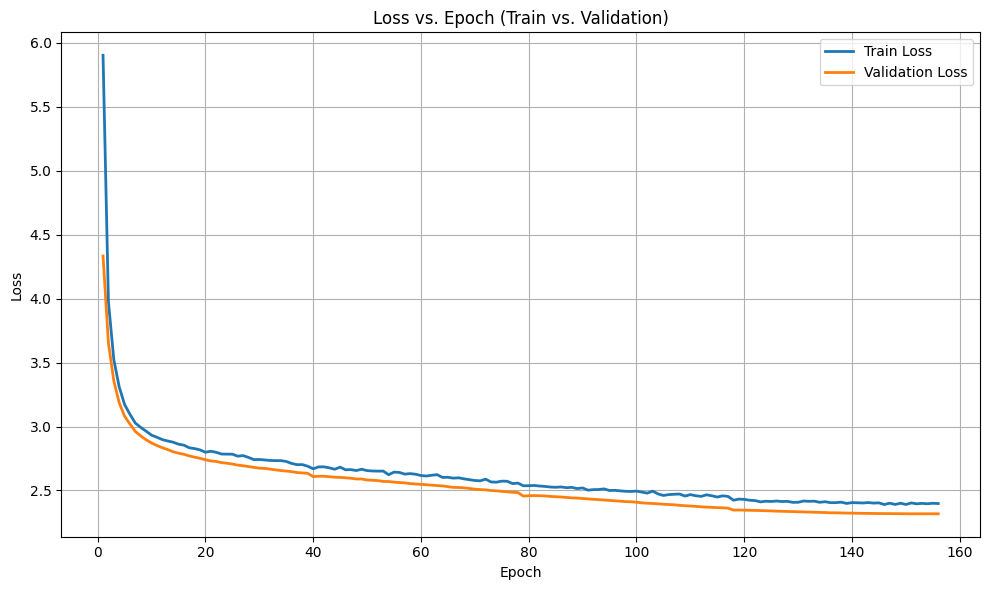

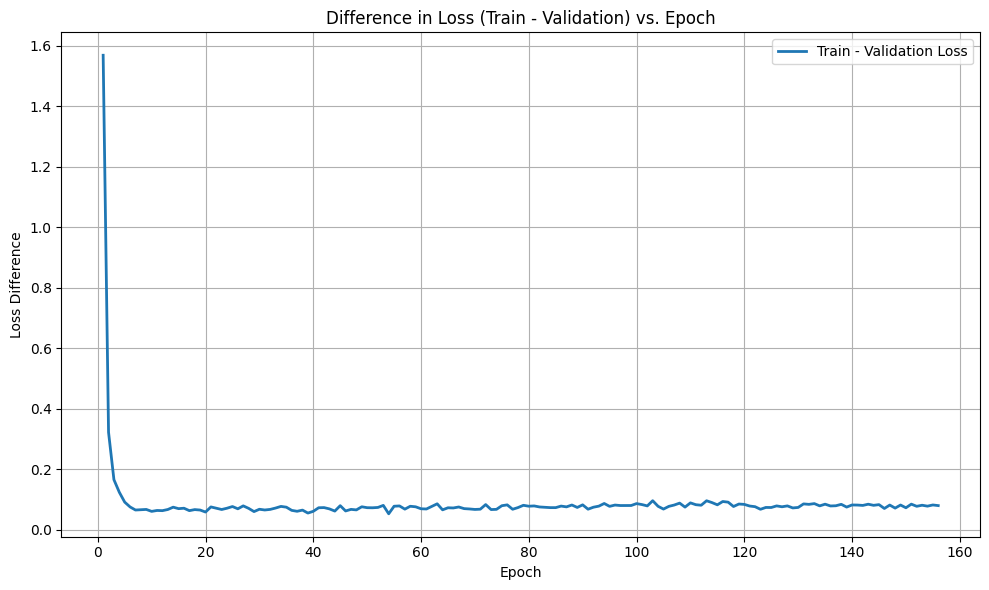

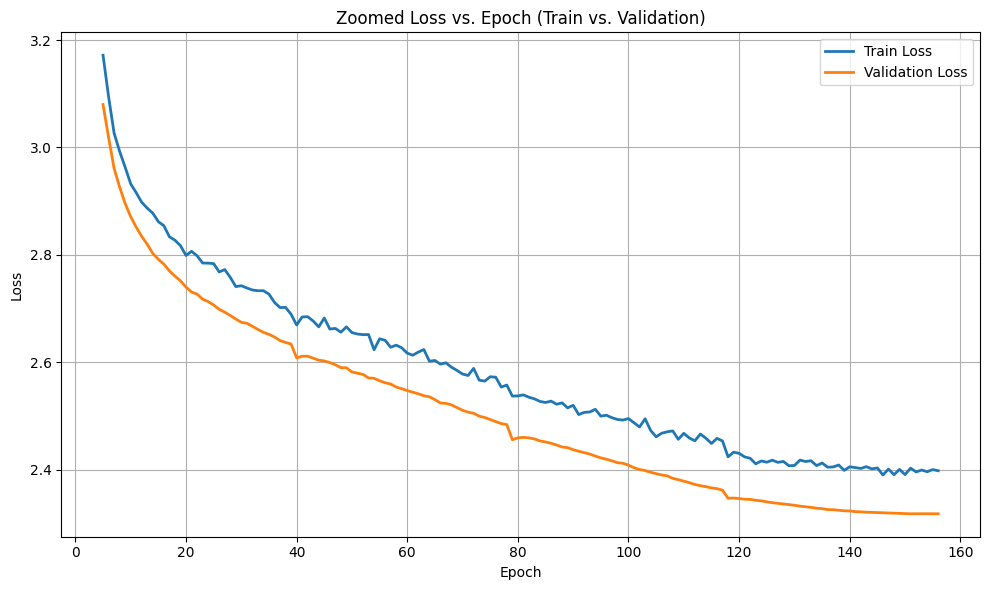

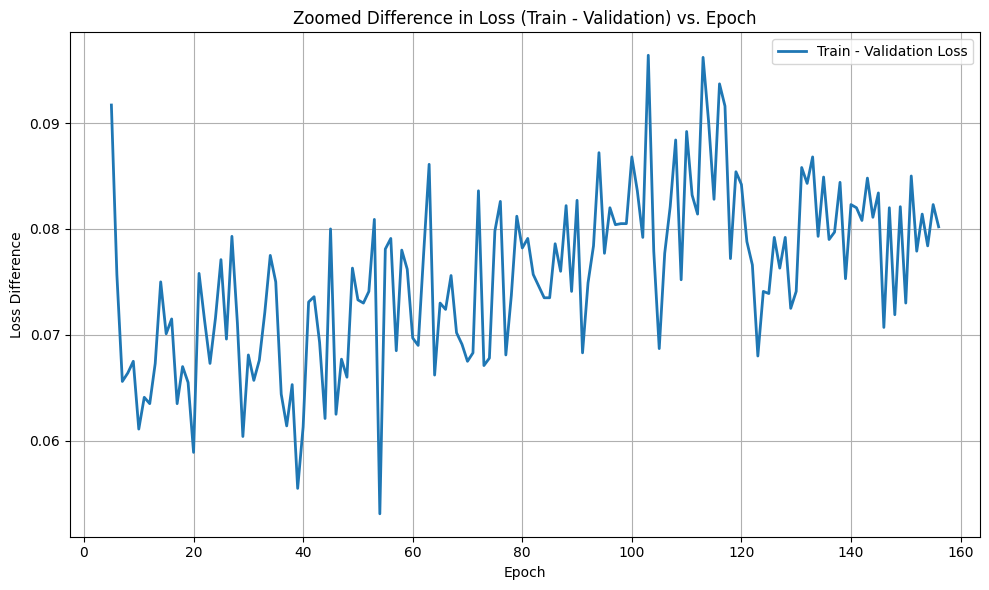

In [ ]:
import matplotlib.pyplot as plt

# Manually defined data (all 156 epochs) for loss
epochs = list(range(1, 157))
train_loss = [
    5.9022, 3.9746, 3.5227, 3.3097, 3.1718,
    3.0948, 3.0267, 2.9928, 2.9632, 2.9323,
    2.9157, 2.8978, 2.8869, 2.8776, 2.8618, 2.8543, 2.8337, 2.8273, 2.8172, 2.7989,
    2.8066, 2.7983, 2.7848, 2.7846, 2.7837, 2.7682, 2.7726, 2.7582, 2.7409, 2.7425,
    2.7383, 2.7346, 2.7332, 2.7332, 2.7269, 2.7114, 2.7018, 2.7021, 2.6894,
    2.6694, 2.6843, 2.6848, 2.6767, 2.6659, 2.6824, 2.6618, 2.6630, 2.6559, 2.6660,
    2.6552, 2.6525, 2.6514, 2.6516, 2.6232, 2.6436, 2.6409, 2.6279, 2.6318, 2.6269,
    2.6169, 2.6131, 2.6189, 2.6237, 2.6019, 2.6033, 2.5965, 2.5989, 2.5907, 2.5847,
    2.5780, 2.5753, 2.5885, 2.5667, 2.5648, 2.5730, 2.5721, 2.5538, 2.5575,
    2.5369, 2.5373, 2.5392, 2.5348, 2.5318, 2.5270, 2.5250, 2.5276, 2.5218, 2.5243,
    2.5150, 2.5198, 2.5025, 2.5066, 2.5074, 2.5123, 2.4996, 2.5013, 2.4967, 2.4934,
    2.4923, 2.4950, 2.4871, 2.4794, 2.4947, 2.4730, 2.4611, 2.4678, 2.4704, 2.4721,
    2.4565, 2.4676, 2.4589, 2.4537, 2.4663, 2.4584, 2.4487, 2.4582, 2.4533, 2.4238,
    2.4325, 2.4303, 2.4237, 2.4211, 2.4108, 2.4160, 2.4138, 2.4176, 2.4135, 2.4152,
    2.4072, 2.4077, 2.4177, 2.4151, 2.4165, 2.4074, 2.4123, 2.4045, 2.4050, 2.4086,
    2.3986, 2.4053, 2.4037, 2.4022, 2.4055, 2.4014, 2.4031, 2.3900, 2.4009, 2.3905,
    2.4004, 2.3907, 2.4027, 2.3957, 2.3992, 2.3961, 2.4000, 2.3979
]

val_loss = [
    4.3329, 3.6520, 3.3568, 3.1854, 3.0801,
    3.0191, 2.9611, 2.9264, 2.8957, 2.8712,
    2.8516, 2.8343, 2.8196, 2.8026, 2.7917, 2.7828, 2.7702, 2.7603, 2.7517, 2.7400,
    2.7308, 2.7269, 2.7175, 2.7130, 2.7066, 2.6986, 2.6933, 2.6871, 2.6805, 2.6744,
    2.6726, 2.6670, 2.6611, 2.6557, 2.6519, 2.6470, 2.6404, 2.6368, 2.6339,
    2.6081, 2.6112, 2.6112, 2.6074, 2.6038, 2.6024, 2.5993, 2.5953, 2.5899, 2.5897,
    2.5819, 2.5795, 2.5773, 2.5707, 2.5701, 2.5655, 2.5618, 2.5594, 2.5538, 2.5507,
    2.5472, 2.5441, 2.5412, 2.5376, 2.5357, 2.5303, 2.5241, 2.5233, 2.5205, 2.5156,
    2.5105, 2.5070, 2.5049, 2.4996, 2.4970, 2.4932, 2.4895, 2.4857, 2.4838,
    2.4557, 2.4591, 2.4601, 2.4591, 2.4572, 2.4535, 2.4515, 2.4490, 2.4458, 2.4421,
    2.4409, 2.4371, 2.4342, 2.4317, 2.4290, 2.4251, 2.4219, 2.4193, 2.4163, 2.4129,
    2.4118, 2.4082, 2.4035, 2.4002, 2.3983, 2.3951, 2.3924, 2.3901, 2.3883, 2.3837,
    2.3813, 2.3784, 2.3757, 2.3723, 2.3701, 2.3682, 2.3659, 2.3645, 2.3617, 2.3466,
    2.3471, 2.3461, 2.3449, 2.3445, 2.3428, 2.3419, 2.3399, 2.3384, 2.3372, 2.3360,
    2.3347, 2.3336, 2.3319, 2.3308, 2.3297, 2.3281, 2.3274, 2.3255, 2.3253, 2.3242,
    2.3233, 2.3230, 2.3217, 2.3214, 2.3207, 2.3203, 2.3197, 2.3193, 2.3189, 2.3186,
    2.3183, 2.3177, 2.3177, 2.3178, 2.3178, 2.3177, 2.3177, 2.3177
]

plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss, linestyle='-', linewidth=2, label='Train Loss')
plt.plot(epochs, val_loss, linestyle='-', linewidth=2, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch (Train vs. Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===========================================================================================================================================\n")

# 1) Compute the difference (Train - Validation) for each epoch
diff_loss = [t - v for t, v in zip(train_loss, val_loss)]

# 2) Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(epochs, diff_loss, linestyle='-', linewidth=2, label='Train - Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Difference")
plt.title("Difference in Loss (Train - Validation) vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===========================================================================================================================================\n")

start_index = 4

epochs_to_plot = epochs[start_index:]
train_loss_to_plot = train_loss[start_index:]
val_loss_to_plot = val_loss[start_index:]

plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, train_loss_to_plot, linestyle='-', linewidth=2, label='Train Loss')
plt.plot(epochs_to_plot, val_loss_to_plot, linestyle='-', linewidth=2, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Zoomed Loss vs. Epoch (Train vs. Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===========================================================================================================================================\n")

# 1) Compute the difference (Train - Validation) for each epoch
diff_loss = [t - v for t, v in zip(train_loss, val_loss)]
diff_loss_to_plot = diff_loss[start_index:]  # slice the difference list as well

# 2) Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, diff_loss_to_plot, linestyle='-', linewidth=2, label='Train - Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Difference")
plt.title("Zoomed Difference in Loss (Train - Validation) vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# **Training Perplexity Over Epochs**

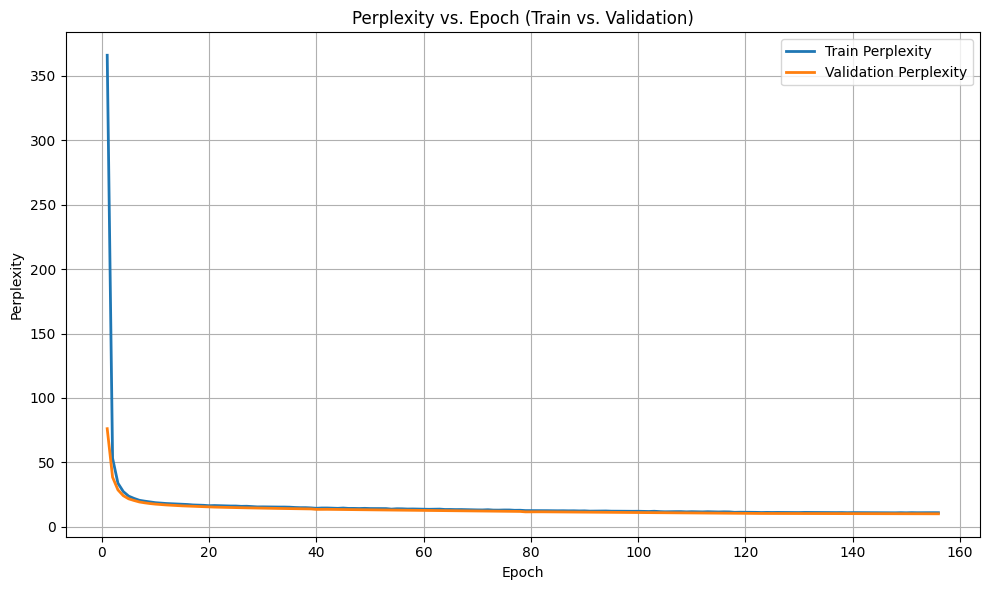

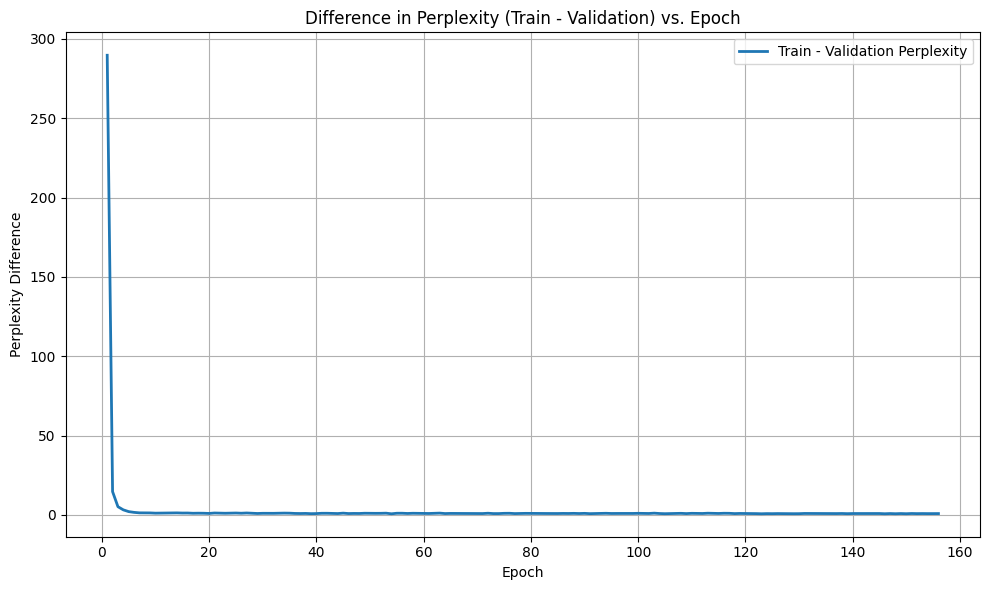

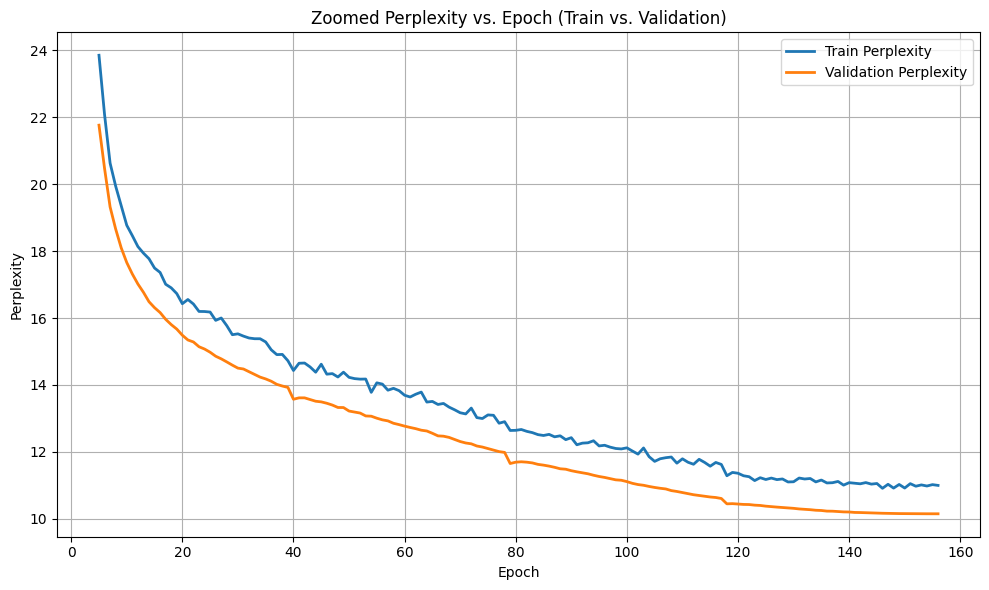

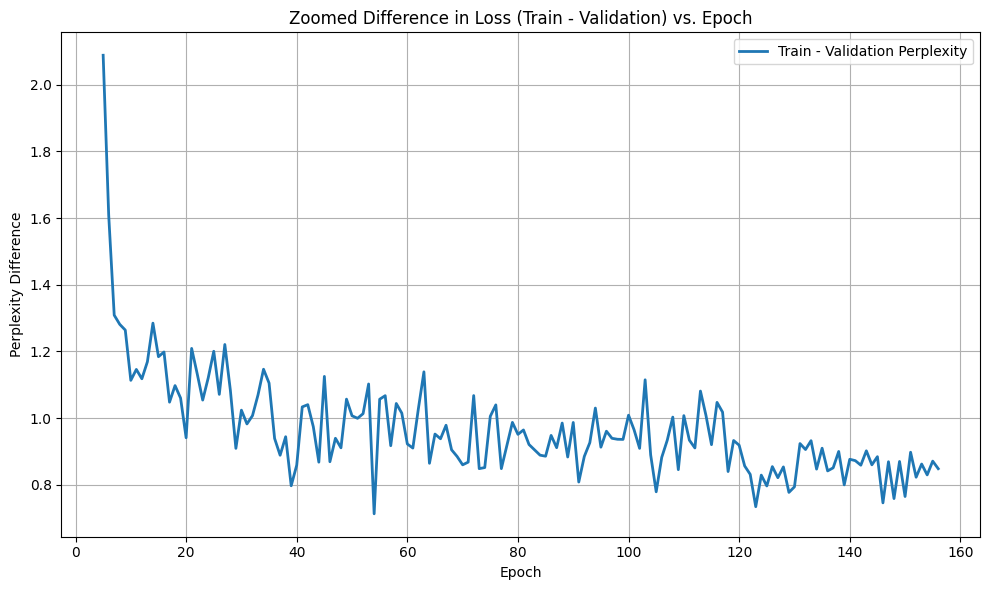

In [ ]:
import matplotlib.pyplot as plt

# Manually defined data (all 156 epochs) for perplexity
epochs = list(range(1, 157))
train_ppl = [
    365.8434, 53.2262, 33.8774, 27.3761, 23.8502, 22.0830, 20.6283, 19.9415, 19.3607, 18.7705,
    18.4614, 18.1358, 17.9384, 17.7721, 17.4933, 17.3620, 17.0096, 16.9016, 16.7300, 16.4282,
    16.5538, 16.4184, 16.1971, 16.1944, 16.1789, 15.9305, 16.0015, 15.7725, 15.5021, 15.5277,
    15.4600, 15.4035, 15.3820, 15.3816, 15.2859, 15.0510, 14.9075, 14.9129, 14.7242,
    14.4326, 14.6492, 14.6558, 14.5379, 14.3822, 14.6206, 14.3231, 14.3395, 14.2389, 14.3827,
    14.2285, 14.1902, 14.1745, 14.1777, 13.7802, 14.0643, 14.0262, 13.8446, 13.8999, 13.8312,
    13.6933, 13.6413, 13.7235, 13.7880, 13.4897, 13.5093, 13.4180, 13.4485, 13.3391, 13.2590,
    13.1707, 13.1353, 13.3100, 13.0257, 12.9977, 13.1058, 13.0948, 12.8578, 12.9036,
    12.6410, 12.6455, 12.6701, 12.6146, 12.5766, 12.5171, 12.4914, 12.5245, 12.4515, 12.4820,
    12.3670, 12.4261, 12.2143, 12.2630, 12.2735, 12.3336, 12.1796, 12.1990, 12.1431, 12.1028,
    12.0898, 12.1225, 12.0266, 11.9348, 12.1188, 11.8585, 11.7180, 11.7962, 11.8279, 11.8478,
    11.6643, 11.7947, 11.6923, 11.6319, 11.7798, 11.6862, 11.5740, 11.6857, 11.6270, 11.2891,
    11.3878, 11.3635, 11.2882, 11.2596, 11.1444, 11.2301, 11.1766, 11.2191, 11.1731, 11.1928,
    11.1031, 11.1089, 11.2205, 11.1914, 11.2066, 11.1048, 11.1603, 11.0735, 11.0805, 11.1186,
    11.0086, 11.0822, 11.0649, 11.0481, 11.0844, 11.0385, 11.0569, 10.9137, 11.0333, 10.9198,
    11.0282, 10.9215, 11.0525, 10.9759, 11.0151, 10.9821, 11.0230, 11.0001
]

val_ppl = [
    76.1673, 38.5531, 28.6960, 24.1774, 21.7617, 20.4735, 19.3195, 18.6603, 18.0967, 17.6573,
    17.3155, 17.0179, 16.7694, 16.4873, 16.3092, 16.1637, 15.9619, 15.8041, 15.6700, 15.4873,
    15.3448, 15.2851, 15.1431, 15.0737, 14.9785, 14.8594, 14.7808, 14.6889, 14.5930, 14.5040,
    14.4776, 14.3963, 14.3126, 14.2351, 14.1810, 14.1121, 14.0190, 13.9689, 13.9273,
    13.5739, 13.6157, 13.6156, 13.5639, 13.5145, 13.4956, 13.4541, 13.4001, 13.3281, 13.3259,
    13.2216, 13.1909, 13.1613, 13.0754, 13.0674, 13.0078, 12.9590, 12.9275, 12.8562, 12.8164,
    12.7710, 12.7313, 12.6951, 12.6493, 12.6254, 12.5573, 12.4801, 12.4701, 12.4343, 12.3742,
    12.3110, 12.2675, 12.2425, 12.1774, 12.1462, 12.1005, 12.0553, 12.0095, 11.9861,
    11.6540, 11.6943, 11.7058, 11.6939, 11.6720, 11.6284, 11.6058, 11.5766, 11.5403, 11.4970,
    11.4838, 11.4393, 11.4062, 11.3782, 11.3472, 11.3036, 11.2669, 11.2384, 11.2038, 11.1664,
    11.1538, 11.1139, 11.0618, 11.0257, 11.0040, 10.9691, 10.9392, 10.9142, 10.8944, 10.8449,
    10.8191, 10.7874, 10.7586, 10.7216, 10.6988, 10.6783, 10.6538, 10.6387, 10.6092, 10.4495,
    10.4551, 10.4449, 10.4319, 10.4285, 10.4103, 10.4013, 10.3803, 10.3647, 10.3520, 10.3393,
    10.3261, 10.3152, 10.2970, 10.2858, 10.2744, 10.2579, 10.2507, 10.2320, 10.2298, 10.2188,
    10.2090, 10.2058, 10.1926, 10.1895, 10.1826, 10.1788, 10.1727, 10.1681, 10.1643, 10.1613,
    10.1584, 10.1568, 10.1550, 10.1533, 10.1530, 10.1526, 10.1522, 10.1520
]

plt.figure(figsize=(10,6))
plt.plot(epochs, train_ppl, linestyle='-', linewidth=2, label='Train Perplexity')
plt.plot(epochs, val_ppl, linestyle='-', linewidth=2, label='Validation Perplexity')
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Epoch (Train vs. Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===========================================================================================================================================\n")

# 1) Compute the difference (Train - Validation) for each epoch
diff_ppl = [t - v for t, v in zip(train_ppl, val_ppl)]

# 2) Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(epochs, diff_ppl, linestyle='-', linewidth=2, label='Train - Validation Perplexity')
plt.xlabel("Epoch")
plt.ylabel("Perplexity Difference")
plt.title("Difference in Perplexity (Train - Validation) vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===========================================================================================================================================\n")

start_index = 4

epochs_to_plot = epochs[start_index:]
train_ppl_to_plot = train_ppl[start_index:]
val_ppl_to_plot = val_ppl[start_index:]

plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, train_ppl_to_plot, linestyle='-', linewidth=2, label='Train Perplexity')
plt.plot(epochs_to_plot, val_ppl_to_plot, linestyle='-', linewidth=2, label='Validation Perplexity')
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Zoomed Perplexity vs. Epoch (Train vs. Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===========================================================================================================================================\n")

# 1) Compute the difference (Train - Validation) for each epoch
diff_ppl = [t - v for t, v in zip(train_ppl, val_ppl)]
diff_ppl_to_plot = diff_ppl[start_index:]  # slice the difference list as well

# 2) Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, diff_ppl_to_plot, linestyle='-', linewidth=2, label='Train - Validation Perplexity')
plt.xlabel("Epoch")
plt.ylabel("Perplexity Difference")
plt.title("Zoomed Difference in Loss (Train - Validation) vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


